In [1]:
import os
import math
import cv2
from tqdm.notebook import tqdm #progress bar
import re # Regular Expression

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #used in training
import torch.nn.utils.prune as prune
from torchvision.models import VGG

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

import time

import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

/home/itadmin/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


The below code will create dataset and save it as numpy array by reading the reading images from folder where folder gives lable name 

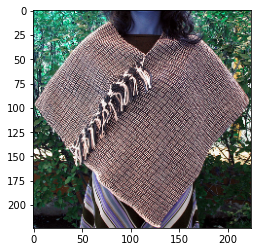

In [2]:
training_data=np.load("/home/itadmin/Downloads/DataSet/MiniImageNet10.npy",allow_pickle=True)

plt.imshow(training_data[3][0])
plt.show()

In [18]:
#modifying our data according to our needs
X= torch.Tensor([i[0] for i in training_data]).view(-1,3,224,224)
X=X/255.0
y=torch.Tensor([i[1] for i in training_data])

VAL_PCT=0.1#using some percent of our training data as test data
val_size=int(len(X)*VAL_PCT)
print("val size:",val_size)

train_X=X[:-val_size]
train_y=y[:-val_size]

test_X=X[-val_size:]
test_y=y[-val_size:]
print(f"Training Data: Input:{len(train_X)} Label:{len(train_y)} \n Test Data: Input{len(test_X)} Label:{len(test_y)}")
      

val size: 1000
Training Data: Input:9000 Label:9000 
 Test Data: Input1000 Label:1000


In [38]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(3,32,5)
    self.conv2=nn.Conv2d(32,64,5)
    self.conv3=nn.Conv2d(64,128,5)

    x=torch.randn(3,224,224).view(-1,3,224,224)
    self._to_linear = None
    self.convs(x)

    self.fc1=nn.Linear(self._to_linear,512)
    self.fc2=nn.Linear(512,1000)

  def convs(self,x):
    x= F.max_pool2d(F.relu(self.conv1(x)),(2,2))
    x= F.max_pool2d(F.relu(self.conv2(x)),(2,2))
    x= F.max_pool2d(F.relu(self.conv3(x)),(2,2))

    #print(x[0].shape)

    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
      print(self._to_linear)
    return x

  def forward(self,x):
    x = self.convs(x)
    #x = x.view(-1,self._to_linear)
    #x = x.view(x.size(0),-1)
    x = F.relu(self.fc1(x.view(x.size(0),-1)))
    x = self.fc2(x)
    return x
    #return F.softmax(x,dim=1)


In [39]:
def fwd_pass(X,y,train=False,is_L1=False):
  
  if train:
    net.zero_grad()
  outputs= net(X)
  print(f"y dimenssion {y.size()} and output dimension is {outputs.size()}")
  matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs,y)]
  acc= matches.count(True)/len(matches)
  loss = F.cross_entropy(outputs, y)

  if train: 
    if is_L1:
      l1_crit = nn.L1Loss(size_average=False)
      reg_loss = 0
      for param in net.parameters():
          reg_loss += l1_crit(param,target=torch.zeros_like(param))
      factor = 0.00001
      loss += factor * reg_loss  
    loss.backward()
    optimizer.step()
  return acc,loss

In [30]:
def test(size = 32):
  random_start = np.random.randint(len(test_X)-size)
  X,y = test_X[random_start: random_start + size],test_y[random_start: random_start + size]
  with torch.no_grad():
    val_acc,val_loss = fwd_pass(X.view(-1,1,50,50).to(device),y.to(device))
  return val_acc,val_loss

#val_acc,val_loss= test2(size=1000)
#print(val_acc,val_loss)

In [31]:
MODEL_NAME = f"model-{int(time.time())}"
EPOCHS = 5
net = Net().to(device)
optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train(EPOCHS=3):
  BATCH_SIZE = 8
  with open("model.log","a") as f:
    for epoch in tqdm(range(EPOCHS)):
      for i in tqdm(range(0,len(train_X),BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,3,224,224).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc,loss= fwd_pass(batch_X,batch_y,train=True,is_L1=True)

        if( i % 50 == 0):
          val_acc,val_loss= test(size=100)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

73728
model-1608542484


In [40]:
train()

y dimenssion torch.Size([8]) and output dimension is torch.Size([8, 1000])




RuntimeError: expected scalar type Long but found Float

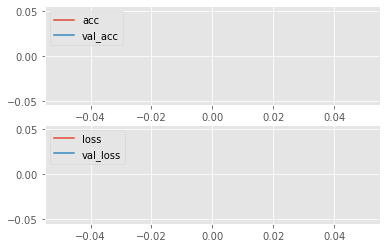

In [33]:
plt.style.use("ggplot")
model_name = MODEL_NAME

def create_acc_loss_graph(model_name):
  contents = open("model.log","r").read().split('\n')

  times=[]
  accuracies = []
  losses= []
  val_accs=[]
  val_losses=[]
  for c in contents:
    if(model_name in c):
      name,timestamp,acc,loss,val_acc,val_loss = c.split(',')
      times.append(float(timestamp))
      accuracies.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))

  fig= plt.figure()
  ax1=plt.subplot2grid((2,1),(0,0))
  ax2=plt.subplot2grid((2,1),(1,0),sharex=ax1)

  ax1.plot(times,accuracies,label="acc")
  ax1.plot(times,val_accs,label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times,losses,label="loss")
  ax2.plot(times,val_losses,label="val_loss")
  ax2.legend(loc=2)

  plt.show()


create_acc_loss_graph(model_name)

Two steps in channel pruning:

1- Channel selection 

2 - Reconstruction

In [ ]:
def select_channels(sparsity, output_feature, fn_next_output_feature):

    num_channel = output_feature.size(1)
    num_pruned = int(math.floor(num_channel * sparsity))

    indices_pruned = []
    while len(indices_pruned) < num_pruned:
        min_diff = 1e10
        min_idx = 0
        for idx in range(num_channel):
            if idx in indices_pruned:
                continue
            indices_try = indices_pruned + [idx]
            output_feature_try = torch.zeros_like(output_feature)
            output_feature_try[:, indices_try, ...] = output_feature[:, indices_try, ...]
            output_feature_try = fn_next_output_feature(output_feature_try)
            output_feature_try_norm = output_feature_try.norm(2)
            if output_feature_try_norm < min_diff:
                min_diff = output_feature_try_norm
                min_idx = idx
        indices_pruned.append(min_idx)

    print(indices_pruned)
    return indices_pruned


def modify_module(module, next_module, indices_pruned):

    if isinstance(module, torch.nn.modules.conv._ConvNd):
        indices_stayed = list(set(range(module.out_channels)) - set(indices_pruned))
        num_channels_stayed = len(indices_stayed)
        module.out_channels = num_channels_stayed

    elif isinstance(module, torch.nn.Linear):
        indices_stayed = list(set(range(module.out_features)) - set(indices_pruned))
        num_channels_stayed = len(indices_stayed)
        module.out_features = num_channels_stayed
    
    else:
        raise NotImplementedError
    
    new_weight = module.weight[indices_stayed, ...].clone()
    del module.weight
    module.weight = torch.nn.Parameter(new_weight)

    if module.bias is not None:
        new_bias = module.bias[indices_stayed, ...].clone()
        del module.bias
        module.bias = torch.nn.Parameter(new_bias)
    
    if isinstance(next_module, torch.nn.modules.conv._ConvNd):
        next_module.in_channels = num_channels_stayed
    
    elif isinstance(next_module, torch.nn.Linear):
        next_module.in_features = num_channels_stayed
    
    else:
        raise NotImplementedError

    new_weight = next_module.weight[:, indices_stayed, ...].clone()
    del next_module.weight
    next_module.weight = torch.nn.Parameter(new_weight)


def reconstruction(next_module, next_input_feature, next_output_feature, cpu=True):

    if next_module.bias is not None:
        bias_size = [1] * next_output_feature.dim()
        bias_size[1] = -1
        next_output_feature -= next_module.bias.view(bias_size)
    
    if cpu:
        next_input_feature = next_input_feature.cpu()
    
    if isinstance(next_module, torch.nn.modules.conv._ConvNd):
        unfold = torch.nn.Unfold(kernel_size=next_module.kernel_size,
                                 dilation=next_module.dilation,
                                 padding=next_module.padding,
                                 stride=next_module.stride)
        if not cpu:
            unfold = unfold.cuda()
        unfold.eval()
        next_input_feature = unfold(next_input_feature)
        next_input_feature = next_input_feature.transpose(1, 2)
        num_fields = next_input_feature.size(0) * next_input_feature.size(1)
        next_input_feature = next_input_feature.reshape(num_fields, -1)
        next_output_feature = next_output_feature.view(next_output_feature.size(0), next_output_feature.size(1), -1)
        next_output_feature = next_output_feature.transpose(1, 2).reshape(num_fields, -1)
    if cpu:
        next_output_feature = next_output_feature.cpu()
    print(next_output_feature.data.shape,next_input_feature.data.shape)
    next_input_feature.data=next_input_feature.data.view(next_output_feature.data.size(0),-1)
    param, _ = torch.lstsq(next_output_feature.data, next_input_feature.data)
    param = param[0:next_input_feature.size(1), :].clone().t().contiguous().view(next_output_feature.size(1), -1)
    if isinstance(next_module, torch.nn.modules.conv._ConvNd):
        param = param.view(next_module.out_channels, next_module.in_channels, *next_module.kernel_size)
    del next_module.weight
    next_module.weight = torch.nn.Parameter(param)


def prune_channel(sparsity, module, next_module, fn_next_input_feature, input_feature, cpu=True):

    assert input_feature.dim() >= 2  # N x C x ...
    if sparsity==0:
        return
    
    if isinstance(module, torch.nn.modules.conv._ConvNd):
        output_feature = module(input_feature)
    
    else:
        output_feature = module(input_feature.view(module.in_features,-1))
    next_input_feature = fn_next_input_feature(output_feature)
    #print(next_module)
    
    if isinstance(next_module, torch.nn.Linear):
      next_input_feature = next_input_feature.view(-1,next_module.in_features);
    next_output_feature = next_module(next_input_feature)

    def fn_next_output_feature(feature):
        if isinstance(next_module, torch.nn.Linear):
          feature = feature.view(-1,next_module.in_features);
        return next_module(fn_next_input_feature(feature))

    indices_pruned = select_channels(sparsity=sparsity, output_feature=output_feature,fn_next_output_feature=fn_next_output_feature)
    print("Channels selected...")
    modify_module(module=module, next_module=next_module, indices_pruned=indices_pruned)
    print("Module modified...")
    if isinstance(module, torch.nn.modules.conv._ConvNd):
        next_input_feature = fn_next_input_feature(module(input_feature))
    else:
        next_input_feature = fn_next_input_feature(module(input_feature.view(-1,module.in_features)))
    reconstruction(next_module=next_module, next_input_feature=next_input_feature,next_output_feature=next_output_feature, cpu=cpu)
    print("Reconstruction done...")


In [ ]:
class MyPruner(object):

    def __init__(self):

        self.rule=[("conv1", 0.5),("conv2", 0.5),("conv3", 0.0),("fc1", 0.0),("fc2", 0.0)]


    def get_param_sparsity(self, module_name):
        rule_id = -1
        for idx, x in enumerate(self.rule):
            m = re.match(x[0], module_name)
            if m is not None and len(module_name) == m.span()[1]:
                rule_id = idx
                break
        if rule_id > -1:
            sparsity = self.rule[rule_id][1]
            return sparsity
        else:
            return 1.0

    @staticmethod
    def get_prune_inputs(model):
        
        features_temp=list(model.children())
        features=[]
        classifier=[]
        for i in features_temp:
          if isinstance(i, torch.nn.modules.conv._ConvNd):
              features.append(i)
              #print("conv")
          if isinstance(i, torch.nn.Linear):
              classifier.append(i)
              #print("linear")

        module_name_dict = dict()
        for n, m in model.named_modules():
            module_name_dict[m] = n

        conv_indices = []
        conv_modules = []
        conv_names = []
        for i, m in enumerate(features):
            if isinstance(m, torch.nn.modules.conv._ConvNd):
                conv_indices.append(i)
                conv_modules.append(m)
                conv_names.append(module_name_dict[m])

        fc_indices = []
        fc_modules = []
        fc_names = []
        for i, m in enumerate(classifier):
            if isinstance(m, torch.nn.Linear):
                fc_indices.append(i)
                fc_modules.append(m)
                fc_names.append(module_name_dict[m])

        def get_fn_conv_input_feature(idx):
            def fn(x):
                for seq_i in range(conv_indices[idx]):
                    x = features[seq_i](x.to(device))
                return x
            return fn

        def get_fn_next_input_feature(idx, module_indices, module_seq):
            def fn(x):
                for seq_i in range(module_indices[idx]+1, module_indices[idx+1]):
                    x = module_seq[seq_i](x.to(device))
                return x
            return fn

        prune_modules = []
        prune_module_names = []
        prune_module_fn = []
        prune_module_fn_next = []

        for i in range(len(conv_indices) - 1):
            prune_modules.append(conv_modules[i])
            prune_module_names.append(conv_names[i])
            prune_module_fn.append(get_fn_conv_input_feature(i))
            prune_module_fn_next.append(get_fn_next_input_feature(i, conv_indices, features))

        prune_modules.append(conv_modules[-1])
        prune_module_names.append(conv_names[-1])
        prune_module_fn.append(get_fn_conv_input_feature(-1))

        def fn_next_input_feature(x):
            for seq_i in range(conv_indices[-1]+1, len(features)):
                x = features[seq_i](x.to(device))
            x = x.view(x.size(0), -1)
            return x
        prune_module_fn_next.append(fn_next_input_feature)

        def get_fn_fc_input_feature(idx):
            def fn(x):
                for i in features:
                    x=i(x)
                #x = features(x)
                x = x.view(x.size(0), -1)
                for seq_i in range(fc_indices[idx]):
                    x = classifier[seq_i](x.to(device))
                return x
            return fn

        for i in range(len(fc_indices) - 1):
            prune_modules.append(fc_modules[i])
            prune_module_names.append(fc_names[i])
            prune_module_fn.append(get_fn_fc_input_feature(i))
            prune_module_fn_next.append(get_fn_next_input_feature(i, fc_indices, classifier))

        prune_modules.append(fc_modules[-1])

        prune_inputs = []
        for i in range(len(prune_module_names)):
            prune_inputs.append((prune_module_names[i], prune_modules[i], prune_modules[i+1],
                                 prune_module_fn[i], prune_module_fn_next[i]))

        return prune_inputs

    def prune_module(self, module_name, module, next_module, fn_input_feature, fn_next_input_feature,
                     input, cpu=True):
        
        sparsity = self.get_param_sparsity(module_name=module_name)
        input_feature = fn_input_feature(input)
        prune_channel(sparsity=sparsity, module=module, next_module=next_module,
                      fn_next_input_feature=fn_next_input_feature,
                      input_feature=input_feature, cpu=cpu)

In [ ]:
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:

pruner = MyPruner()
prune_inputs = pruner.get_prune_inputs(model=net)
i=0
for (module_name, module, next_module,fn_input_feature, fn_next_input_feature) in prune_inputs:

    #input, _ = input_iter.__next__()
    input = train_X[i:i+100].view(-1,1,50,50).to(device)
    i+=100
    #print(module_name)
    if isinstance(module, torch.nn.Linear):
        break
    pruner.prune_module(module_name=module_name, module=module,next_module=next_module, fn_input_feature=fn_input_feature,fn_next_input_feature=fn_next_input_feature,input=input)
    net._to_linear=None
    #train(EPOCHS=1)
    

[19, 11, 12, 27, 20, 0, 31, 17, 23, 14, 16, 5, 1, 30, 4, 2]
torch.Size([176400, 64]) torch.Size([176400, 400])


KeyboardInterrupt: ignored

In [ ]:
net


Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

512


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


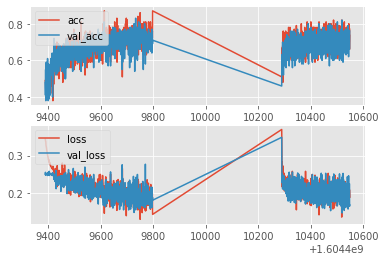

In [ ]:


train(EPOCHS=3)
plt.style.use("ggplot")
model_name = MODEL_NAME

create_acc_loss_graph(model_name)